In [1]:
import tensorflow as tf
import keras
import mtcnn
import matplotlib.pyplot as plt
from keras.applications import ResNet50
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense
import tensorflow as tf
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.callbacks import ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.layers import Layer, InputSpec
from keras.preprocessing.image import ImageDataGenerator
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.optimizers import SGD, Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
import json

print("Versión de TensorFlow:", tf.__version__)
print("Versión de Keras:", keras.__version__)
print("Versión de MTCNN:", mtcnn.__version__)

def plot_learning_curve(history, title):
    plt.figure()
    plt.plot(history.history['accuracy'], label='train accuracy')
    plt.plot(history.history['val_accuracy'], label='val accuracy')
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy/Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig("img/"+title)
    plt.show()

Versión de TensorFlow: 2.12.0
Versión de Keras: 2.12.0
Versión de MTCNN: 0.1.0


## Generacion de datos

In [2]:

# Configuración del aumento de datos
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=0.2  # Usar un 20% de datos para validación
)

train_generator = train_datagen.flow_from_directory(
    'output/train/',  # Ruta del nuevo conjunto de entrenamiento
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    'output/val/',  # Ruta del nuevo conjunto de validación
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Guardar el mapeo de clases en un archivo JSON
class_indices = train_generator.class_indices
inverse_class_indices = {v: k for k, v in class_indices.items()}
with open('class_indices.json', 'w') as f:
    json.dump(inverse_class_indices, f)

Found 7202 images belonging to 38 classes.
Found 2263 images belonging to 38 classes.


## Modelo Resnet50 pesos imagenet

In [3]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congela las capas para que no se actualicen durante el entrenamiento
for layer in base_model.layers:
    layer.trainable = False

for layer in base_model.layers[-20:]:  # Descongelar las últimas 20 capas
    layer.trainable = True

In [4]:
num_classes = len(class_indices)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

Epoch 1/10
226/226 [==============================] - 2611s 12s/step - loss: 2.2796 - accuracy: 0.3929 - val_loss: 1.5028 - val_accuracy: 0.5793 - lr: 1.0000e-04
Epoch 2/10
226/226 [==============================] - 1697s 8s/step - loss: 1.0813 - accuracy: 0.6973 - val_loss: 1.0493 - val_accuracy: 0.7017 - lr: 1.0000e-04
Epoch 3/10
226/226 [==============================] - 1291s 6s/step - loss: 0.7091 - accuracy: 0.8024 - val_loss: 0.9150 - val_accuracy: 0.7503 - lr: 1.0000e-04
Epoch 4/10
226/226 [==============================] - 2594s 12s/step - loss: 0.5170 - accuracy: 0.8491 - val_loss: 0.8145 - val_accuracy: 0.7738 - lr: 1.0000e-04
Epoch 5/10
226/226 [==============================] - 791s 4s/step - loss: 0.4038 - accuracy: 0.8891 - val_loss: 0.8015 - val_accuracy: 0.7751 - lr: 1.0000e-04
Epoch 6/10
226/226 [==============================] - 2466s 11s/step - loss: 0.3076 - accuracy: 0.9111 - val_loss: 0.7741 - val_accuracy: 0.7932 - lr: 1.0000e-04
Epoch 7/10
226/226 [============

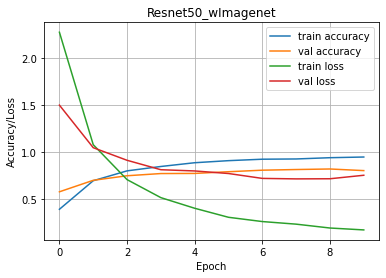

In [5]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
# Puedes probar con SGD
#model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3, min_lr=0.00001)

history = model.fit(
    train_generator,
    epochs=10,  # Aumentar las épocas
    validation_data=validation_generator,
    callbacks=[reduce_lr, early_stopping]
)
model.save('modelos/modelo_resnet50_wImagenet.h5')

plot_learning_curve(history, "Resnet50_wImagenet")

In [6]:
# Carga el modelo entrenado desde el archivo HDF5
model = tf.keras.models.load_model('modelo_resnet50_wImagenet.h5')

# Convierte el modelo a TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Guarda el modelo TFLite en un archivo
with open('modelos/modelo_resnet50_wImagenet.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/g1/ttxr0zx14z52t9z0s70ndybh0000gn/T/tmp66z7llt8/assets


INFO:tensorflow:Assets written to: /var/folders/g1/ttxr0zx14z52t9z0s70ndybh0000gn/T/tmp66z7llt8/assets


## Modelo VGGFace

Epoch 1/10
226/226 [==============================] - 7816s 35s/step - loss: 3.6786 - accuracy: 0.0611 - val_loss: 4.3340 - val_accuracy: 0.0871 - lr: 0.0010
Epoch 2/10
226/226 [==============================] - 9509s 42s/step - loss: 3.1916 - accuracy: 0.1340 - val_loss: 3.0224 - val_accuracy: 0.1684 - lr: 0.0010
Epoch 3/10
226/226 [==============================] - 5654s 25s/step - loss: 2.5900 - accuracy: 0.2613 - val_loss: 2.5442 - val_accuracy: 0.2996 - lr: 0.0010
Epoch 4/10
226/226 [==============================] - 3407s 15s/step - loss: 1.9699 - accuracy: 0.4452 - val_loss: 2.9482 - val_accuracy: 0.2740 - lr: 0.0010
Epoch 5/10
226/226 [==============================] - 639s 3s/step - loss: 1.4783 - accuracy: 0.5826 - val_loss: 3.7688 - val_accuracy: 0.3084 - lr: 0.0010
Epoch 6/10
226/226 [==============================] - 638s 3s/step - loss: 1.1548 - accuracy: 0.6794 - val_loss: 1.2588 - val_accuracy: 0.6549 - lr: 0.0010
Epoch 7/10
226/226 [==============================] - 64

INFO:tensorflow:Assets written to: /var/folders/g1/ttxr0zx14z52t9z0s70ndybh0000gn/T/tmp71juynv7/assets


INFO:tensorflow:Assets written to: /var/folders/g1/ttxr0zx14z52t9z0s70ndybh0000gn/T/tmp71juynv7/assets


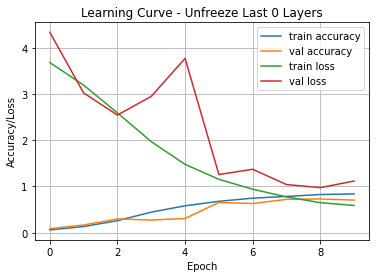

Epoch 1/10
226/226 [==============================] - 168s 737ms/step - loss: 1.0131 - accuracy: 0.8421 - val_loss: 0.2173 - val_accuracy: 0.9501 - lr: 0.0010
Epoch 2/10
226/226 [==============================] - 166s 733ms/step - loss: 0.2539 - accuracy: 0.9367 - val_loss: 0.2020 - val_accuracy: 0.9536 - lr: 0.0010
Epoch 3/10
226/226 [==============================] - 167s 737ms/step - loss: 0.2026 - accuracy: 0.9456 - val_loss: 0.1740 - val_accuracy: 0.9598 - lr: 0.0010
Epoch 4/10
226/226 [==============================] - 167s 741ms/step - loss: 0.1759 - accuracy: 0.9538 - val_loss: 0.1803 - val_accuracy: 0.9567 - lr: 0.0010
Epoch 5/10
226/226 [==============================] - 167s 740ms/step - loss: 0.1405 - accuracy: 0.9629 - val_loss: 0.1730 - val_accuracy: 0.9598 - lr: 0.0010
Epoch 6/10
226/226 [==============================] - 166s 736ms/step - loss: 0.1435 - accuracy: 0.9620 - val_loss: 0.1643 - val_accuracy: 0.9620 - lr: 0.0010
Epoch 7/10
226/226 [==========================

INFO:tensorflow:Assets written to: /var/folders/g1/ttxr0zx14z52t9z0s70ndybh0000gn/T/tmpnw06du1q/assets


INFO:tensorflow:Assets written to: /var/folders/g1/ttxr0zx14z52t9z0s70ndybh0000gn/T/tmpnw06du1q/assets


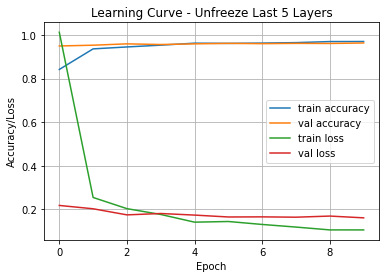

Epoch 1/10
226/226 [==============================] - 174s 762ms/step - loss: 0.9628 - accuracy: 0.8260 - val_loss: 0.2160 - val_accuracy: 0.9505 - lr: 0.0010
Epoch 2/10
226/226 [==============================] - 171s 758ms/step - loss: 0.2813 - accuracy: 0.9278 - val_loss: 0.1908 - val_accuracy: 0.9563 - lr: 0.0010
Epoch 3/10
226/226 [==============================] - 173s 767ms/step - loss: 0.2123 - accuracy: 0.9452 - val_loss: 0.1736 - val_accuracy: 0.9576 - lr: 0.0010
Epoch 4/10
226/226 [==============================] - 172s 763ms/step - loss: 0.1943 - accuracy: 0.9447 - val_loss: 0.1881 - val_accuracy: 0.9563 - lr: 0.0010
Epoch 5/10
226/226 [==============================] - 173s 765ms/step - loss: 0.1736 - accuracy: 0.9535 - val_loss: 0.1643 - val_accuracy: 0.9602 - lr: 0.0010
Epoch 6/10
226/226 [==============================] - 173s 766ms/step - loss: 0.1577 - accuracy: 0.9581 - val_loss: 0.1595 - val_accuracy: 0.9624 - lr: 0.0010
Epoch 7/10
226/226 [==========================

INFO:tensorflow:Assets written to: /var/folders/g1/ttxr0zx14z52t9z0s70ndybh0000gn/T/tmpq39acr0y/assets


INFO:tensorflow:Assets written to: /var/folders/g1/ttxr0zx14z52t9z0s70ndybh0000gn/T/tmpq39acr0y/assets


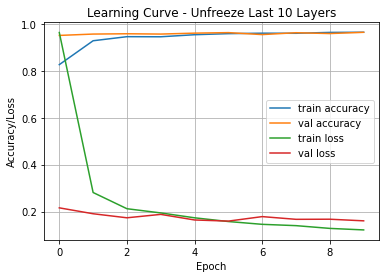

Epoch 1/10
226/226 [==============================] - 183s 806ms/step - loss: 0.5729 - accuracy: 0.8848 - val_loss: 0.2055 - val_accuracy: 0.9505 - lr: 0.0010
Epoch 2/10
226/226 [==============================] - 182s 804ms/step - loss: 0.2019 - accuracy: 0.9486 - val_loss: 0.1712 - val_accuracy: 0.9554 - lr: 0.0010
Epoch 3/10
226/226 [==============================] - 181s 801ms/step - loss: 0.1860 - accuracy: 0.9510 - val_loss: 0.1644 - val_accuracy: 0.9589 - lr: 0.0010
Epoch 4/10
226/226 [==============================] - 182s 806ms/step - loss: 0.1581 - accuracy: 0.9574 - val_loss: 0.1625 - val_accuracy: 0.9620 - lr: 0.0010
Epoch 5/10
226/226 [==============================] - 181s 801ms/step - loss: 0.1401 - accuracy: 0.9624 - val_loss: 0.1552 - val_accuracy: 0.9624 - lr: 0.0010
Epoch 6/10
226/226 [==============================] - 182s 806ms/step - loss: 0.1341 - accuracy: 0.9645 - val_loss: 0.1497 - val_accuracy: 0.9642 - lr: 0.0010
Epoch 7/10
226/226 [==========================

INFO:tensorflow:Assets written to: /var/folders/g1/ttxr0zx14z52t9z0s70ndybh0000gn/T/tmpyizzbcw8/assets


INFO:tensorflow:Assets written to: /var/folders/g1/ttxr0zx14z52t9z0s70ndybh0000gn/T/tmpyizzbcw8/assets


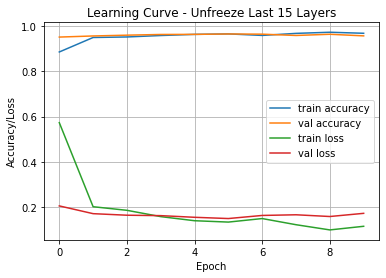

In [7]:
layers_to_unfreeze = [0, 5, 10, 15]

for unfreeze_layers in layers_to_unfreeze:
    # Cargar el modelo base VGGFace
    base_model = VGGFace(model='senet50', include_top=False, input_shape=(224, 224, 3))

    # Congela las capas para que no se actualicen durante el entrenamiento
    for layer in base_model.layers:
        layer.trainable = False

    # Descongelar las últimas 'unfreeze_layers' capas
    for layer in base_model.layers[-unfreeze_layers:]:
        layer.trainable = True

    # Añadir capas superiores
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compilar el modelo
    model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

    # Configurar callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3, min_lr=0.00001)

    # Entrenar el modelo
    history = model.fit(
        train_generator,
        epochs=10,  # Ajusta según tus necesidades
        validation_data=validation_generator,
        callbacks=[reduce_lr, early_stopping]
    )

    # Guardar el modelo entrenado
    model_filename = f'modelos/modelo_vggface_senet50_unfreeze_{unfreeze_layers}.h5'
    model.save(model_filename)

    # Carga el modelo entrenado desde el archivo HDF5
    model = tf.keras.models.load_model(model_filename)

    # Convierte el modelo a TFLite
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()

    # Guarda el modelo TFLite en un archivo
    tflite_filename = f'modelos/modelo_vggface_senet50_unfreeze_{unfreeze_layers}.tflite'
    with open(tflite_filename, 'wb') as f:
        f.write(tflite_model)

    # Plot learning curve
    plot_learning_curve(history, f'Learning Curve - Unfreeze Last {unfreeze_layers} Layers')

## Modelo a mano

Epoch 1/10
226/226 [==============================] - 1162s 5s/step - loss: 8.9056 - accuracy: 0.0386 - val_loss: 3.5908 - val_accuracy: 0.0429 - lr: 0.0010
Epoch 2/10
226/226 [==============================] - 112s 493ms/step - loss: 3.5868 - accuracy: 0.0407 - val_loss: 3.5801 - val_accuracy: 0.0455 - lr: 0.0010
Epoch 3/10
226/226 [==============================] - 987s 4s/step - loss: 3.5877 - accuracy: 0.0389 - val_loss: 3.5831 - val_accuracy: 0.0429 - lr: 0.0010
Epoch 4/10
226/226 [==============================] - 418s 2s/step - loss: 3.5862 - accuracy: 0.0421 - val_loss: 3.5828 - val_accuracy: 0.0429 - lr: 0.0010
Epoch 5/10
226/226 [==============================] - 482s 2s/step - loss: 3.5851 - accuracy: 0.0422 - val_loss: 3.5827 - val_accuracy: 0.0429 - lr: 0.0010
Epoch 6/10
226/226 [==============================] - 1166s 5s/step - loss: 3.5850 - accuracy: 0.0439 - val_loss: 3.5826 - val_accuracy: 0.0429 - lr: 2.0000e-04
Epoch 7/10
226/226 [==============================] - 1

INFO:tensorflow:Assets written to: /var/folders/g1/ttxr0zx14z52t9z0s70ndybh0000gn/T/tmpw61c6yvr/assets


INFO:tensorflow:Assets written to: /var/folders/g1/ttxr0zx14z52t9z0s70ndybh0000gn/T/tmpw61c6yvr/assets


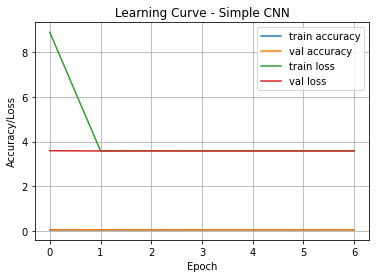

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Configurar callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

# Entrenar el modelo
history = model.fit(
    train_generator,
    epochs=10,  # Ajusta según tus necesidades
    validation_data=validation_generator,
    callbacks=[reduce_lr, early_stopping]
)

# Guardar el modelo entrenado
model.save('modelos/modelo_cnn_simple.h5')

model = tf.keras.models.load_model(model_filename)

# Convierte el modelo a TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Guarda el modelo TFLite en un archivo
tflite_filename = f'modelos/modelo_cnn_simple.tflite'
with open(tflite_filename, 'wb') as f:
    f.write(tflite_model)
        
# Plot learning curve
plot_learning_curve(history, 'Learning Curve - Simple CNN')

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import random
from tensorflow.keras.models import load_model

model = tf.keras.models.load_model('modelos/modelo_vggface_senet50_unfreeze_10.h5',compile=False)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
def representative_dataset_gen():
    for _ in range(1000):
        # Get sample input data as a numpy array in a method of your choosing.
        yield [input]
converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8  # or tf.uint8
converter.inference_output_type = tf.int8  # or tf.uint8
tflite_quant_model = converter.convert()

with open('test_quant.tflite', 'wb') as f:
  f.write(tflite_quant_model)

In [12]:
import json

# Lee el archivo JSON
with open('class_indices.json', 'r') as f:
    class_indices = json.load(f)

# Convierte el diccionario a una lista de labels
labels = [label for label in class_indices.values()]

# Escribe los labels en un archivo de texto plano
with open('labels.txt', 'w') as f:
    f.write('\n'.join(labels))
